# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook computes predicted expression correlations between all genes in the MultiPLIER models.

It also has a parameter set for papermill to run on a single chromosome to run in parallel (see under `Settings` below).

This notebook is not directly run. See README.md.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from random import sample, seed
import warnings
from pathlib import Path

import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene

# Settings

In [3]:
# reference panel
REFERENCE_PANEL = "GTEX_V8"
# REFERENCE_PANEL = "1000G"

# prediction models
## mashr
EQTL_MODEL = "MASHR"

# this is the default value used in S-MultiXcan to select the
# top principal components of the expression correlation matrix
SMULTIXCAN_CONDITION_NUMBER = 30

# specifies a single chromosome value
# by default, run on all chromosomes
chromosome = None

In [4]:
# Parameters
chromosome = 20
REFERENCE_PANEL = "1000G"
EQTL_MODEL = "MASHR"


In [5]:
EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS"][f"{EQTL_MODEL}_PREFIX"]

In [6]:
display(f"Using eQTL model: {EQTL_MODEL} / {EQTL_MODEL_FILES_PREFIX}")

'Using eQTL model: MASHR / mashr_'

In [7]:
display(f"S-MultiXcan condition number: {SMULTIXCAN_CONDITION_NUMBER}")

'S-MultiXcan condition number: 30'

In [8]:
REFERENCE_PANEL_DIR = conf.PHENOMEXCAN["LD_BLOCKS"][f"{REFERENCE_PANEL}_GENOTYPE_DIR"]

In [9]:
display(f"Using reference panel folder: {str(REFERENCE_PANEL_DIR)}")

'Using reference panel folder: /opt/data/data/phenomexcan/ld_blocks/reference_panel_1000G'

In [10]:
OUTPUT_DIR_BASE = (
    conf.PHENOMEXCAN["LD_BLOCKS"][f"GENE_CORRS_DIR"]
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

In [11]:
display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr'

In [12]:
assert (
    chromosome is not None
), "You have to select one chromosome (format: number between 1 and 22)"

In [13]:
chromosome = str(chromosome)

In [14]:
display(f"Working on chromosome {chromosome}")

'Working on chromosome 20'

In [15]:
# This paramter, if True, computes the correlation between closeby genes only
COMPUTE_CORRELATIONS_WITHIN_DISTANCE = False
display(f"Compute correlation within distance {COMPUTE_CORRELATIONS_WITHIN_DISTANCE}")

'Compute correlation within distance False'

# Load data

## Prediction model tissues

In [16]:
prediction_model_tissues = conf.PHENOMEXCAN["PREDICTION_MODELS"][
    f"{EQTL_MODEL}_TISSUES"
].split(" ")

In [17]:
len(prediction_model_tissues)

49

In [18]:
prediction_model_tissues[:5]

['Skin_Not_Sun_Exposed_Suprapubic',
 'Cells_EBV-transformed_lymphocytes',
 'Brain_Frontal_Cortex_BA9',
 'Kidney_Cortex',
 'Brain_Substantia_nigra']

## MultiPLIER Z

In [19]:
multiplier_z_genes = pd.read_pickle(
    conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"]
).index.tolist()

In [20]:
len(multiplier_z_genes)

6750

In [21]:
multiplier_z_genes[:10]

['GAS6',
 'MMP14',
 'DSP',
 'MARCKSL1',
 'SPARC',
 'CTSD',
 'EPAS1',
 'PALLD',
 'PHC2',
 'LGALS3BP']

## Get gene objects

In [22]:
multiplier_gene_obj = {
    gene_name: Gene(name=gene_name)
    for gene_name in multiplier_z_genes
    if gene_name in Gene.GENE_NAME_TO_ID_MAP
}

In [23]:
len(multiplier_gene_obj)

6454

In [24]:
multiplier_gene_obj["GAS6"].ensembl_id

'ENSG00000183087'

In [25]:
_gene_obj = list(multiplier_gene_obj.values())

genes_info = pd.DataFrame(
    {
        "name": [g.name for g in _gene_obj],
        "id": [g.ensembl_id for g in _gene_obj],
        "chr": [g.chromosome for g in _gene_obj],
        "band": [g.band for g in _gene_obj],
        "start_position": [g.get_attribute("start_position") for g in _gene_obj],
    }
)

In [26]:
genes_info.shape

(6454, 5)

In [27]:
genes_info.head()

,name,id,chr,band,start_position
0,GAS6,ENSG00000183087,13,13q34,113820549.0
1,MMP14,ENSG00000157227,14,14q11.2,22836560.0
2,DSP,ENSG00000096696,6,6p24.3,7541617.0
3,MARCKSL1,ENSG00000175130,1,1p35.1,32333839.0
4,SPARC,ENSG00000113140,5,5q33.1,151661096.0


# Test

In [28]:
chromosome_genes_info = genes_info[genes_info["chr"] == chromosome]
display(chromosome_genes_info)

,name,id,chr,band,start_position
11,TGM2,ENSG00000198959,20,20q11.23,38127385.0
23,CST3,ENSG00000101439,20,20p11.21,23626706.0
36,TOMM34,ENSG00000025772,20,20q13.12,44942130.0
44,PLTP,ENSG00000100979,20,20q13.12,45898621.0
67,PKIG,ENSG00000168734,20,20q13.12,44531785.0
...,...,...,...,...,...
6300,MYL9,ENSG00000101335,20,20q11.23,36541497.0
6388,EDN3,ENSG00000124205,20,20q13.32,59300443.0
6393,CSNK2A1,ENSG00000101266,20,20p13,472498.0
6405,PREX1,ENSG00000124126,20,20q13.13,48624252.0


In [29]:
seed(0)
_gene_list_ids = sample(chromosome_genes_info["id"].tolist(), 5)
selected_chromosome_genes_obj = [Gene(ensembl_id=g_id) for g_id in _gene_list_ids]
display(len(selected_chromosome_genes_obj))

5

In [30]:
for gene_idx1 in range(0, len(selected_chromosome_genes_obj) - 1):
    gene_obj1 = selected_chromosome_genes_obj[gene_idx1]

    for gene_idx2 in range(gene_idx1 + 1, len(selected_chromosome_genes_obj)):
        gene_obj2 = selected_chromosome_genes_obj[gene_idx2]

        c = gene_obj1.get_ssm_correlation(
            gene_obj2,
        )

        print(f"{gene_obj1.name} / {gene_obj2.name}: {c}")

NTSR1 / CRNKL1: 0.0
NTSR1 / ADA: 0.0
NTSR1 / FKBP1A: 0.0
NTSR1 / PTPN1: 0.0
CRNKL1 / ADA: 0.0
CRNKL1 / FKBP1A: 0.0
CRNKL1 / PTPN1: 0.0
ADA / FKBP1A: 0.0
ADA / PTPN1: 0.0
FKBP1A / PTPN1: 0.0


# Compute correlation per chromosome

In [31]:
output_dir = OUTPUT_DIR_BASE / "by_chr"
output_dir.mkdir(exist_ok=True, parents=True)
output_file = output_dir / f"gene_corrs-chr{chromosome}.pkl"
display(output_file)

PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/gene_corrs-chr20.pkl')

In [32]:
warnings.filterwarnings("error")

In [33]:
# standard checks
all_chrs = genes_info["chr"].dropna().unique()
assert all_chrs.shape[0] == 22

# select chromosome given by the user
assert chromosome in all_chrs

# run only on the chromosome specified
all_chrs = [chromosome]
genes_chr = genes_info[genes_info["chr"] == chromosome]

# For testing purposes
# genes_chr = genes_chr.sample(n=20)

print(f"Number of genes in chromosome: {genes_chr.shape[0]}", flush=True)

# sort genes by starting position to make visualizations better later
genes_chr = genes_chr.sort_values("start_position")

gene_chr_objs = [Gene(ensembl_id=gene_id) for gene_id in genes_chr["id"]]
gene_chr_ids = [g.ensembl_id for g in gene_chr_objs]

n = len(gene_chr_objs)
n_comb = int(n * (n - 1) / 2.0)
print(f"Number of gene combinations: {n_comb}", flush=True)

gene_corrs = []

pbar = tqdm(ncols=100, total=n_comb)
i = 0
for gene_idx1 in range(0, len(gene_chr_objs) - 1):
    gene_obj1 = gene_chr_objs[gene_idx1]

    for gene_idx2 in range(gene_idx1 + 1, len(gene_chr_objs)):
        gene_obj2 = gene_chr_objs[gene_idx2]

        pbar.set_description(f"{gene_obj1.ensembl_id} / {gene_obj2.ensembl_id}")

        try:
            # FIXME: compute the correlation of the sum of squares of the model using all
            # the available tissues; this could be problematic because for some results
            # (computed on a specific phenotype/GWAS) we might not have all the tissues
            # available, which can certainly bias the correlation estimation.
            # Since this depends on the GWAS on a specific phenotype, we should ideally have
            # one correlation matrix per GWAS. I should look at how we can improve this.
            r = gene_obj1.get_ssm_correlation(
                other_gene=gene_obj2,
                condition_number=SMULTIXCAN_CONDITION_NUMBER,
                reference_panel=REFERENCE_PANEL,
                model_type=EQTL_MODEL,
                use_within_distance=COMPUTE_CORRELATIONS_WITHIN_DISTANCE,
            )

            if r is None:
                # if r is None, it's very likely because:
                #  * one of the genes has no prediction models
                #  * all the SNPs predictors for the gene are not present in the reference
                #    panel

                r = 0.0

            gene_corrs.append(r)
        except Warning:
            print(
                f"RuntimeWarning for genes {gene_obj1.ensembl_id} and {gene_obj2.ensembl_id}",
                flush=True,
            )
            import traceback

            print(traceback.format_exc(), flush=True)
        except Exception as e:
            print(
                f"Exception for genes {gene_obj1.ensembl_id} and {gene_obj2.ensembl_id}",
                flush=True,
            )
            import traceback

            print(traceback.format_exc(), flush=True)
            gene_corrs.append(np.nan)

        pbar.update(1)

pbar.close()

# testing
gene_corrs_flat = pd.Series(gene_corrs)
print(f"Min/max values: {gene_corrs_flat.min()} / {gene_corrs_flat.max()}")
assert gene_corrs_flat.min() >= -1.001
assert gene_corrs_flat.max() <= 1.001

# save
# FIXME: consider saving only the condenced matrix here. See here for
# more details: https://github.com/greenelab/phenoplier/pull/38#discussion_r634600813
gene_corrs_data = squareform(np.array(gene_corrs, dtype=np.float64))
np.fill_diagonal(gene_corrs_data, 1.0)

gene_corrs_df = pd.DataFrame(
    data=gene_corrs_data,
    index=gene_chr_ids,
    columns=gene_chr_ids,
)

output_dir.mkdir(exist_ok=True, parents=True)
display(output_file)

gene_corrs_df.to_pickle(output_file)

Number of genes in chromosome: 187
Number of gene combinations: 17391


ENSG00000171700 / ENSG00000125510: 100%|██████████████████████| 17391/17391 [25:07<00:00, 11.54it/s]

Min/max values: 3.5267260245432646e-09 / 0.985687112048068


PosixPath('/opt/data/data/phenomexcan/ld_blocks/gene_corrs/1000g/mashr/by_chr/gene_corrs-chr20.pkl')

# Testing

In [34]:
gene_corrs_df.shape

(187, 187)

In [35]:
gene_corrs_df.head()

,ENSG00000101255,ENSG00000125826,ENSG00000101266,ENSG00000101280,ENSG00000125818,ENSG00000101298,ENSG00000088832,ENSG00000101307,ENSG00000089012,ENSG00000198053,...,ENSG00000092758,ENSG00000101191,ENSG00000101199,ENSG00000243509,ENSG00000203896,ENSG00000101152,ENSG00000198276,ENSG00000101161,ENSG00000171700,ENSG00000125510
ENSG00000101255,1.000000,0.050683,0.017861,0.011775,0.002720,0.008144,0.013091,0.003198,0.010352,0.010639,...,0.010817,0.004357,0.004852,0.007574,0.007163,0.009123,0.013946,0.006803,0.003290,0.002943
ENSG00000125826,0.050683,1.000000,0.066958,0.008757,0.004395,0.016771,0.015061,0.008082,0.013727,0.014500,...,0.017529,0.007586,0.005689,0.011303,0.008357,0.011255,0.013041,0.010534,0.006084,0.010055
ENSG00000101266,0.017861,0.066958,1.000000,0.014596,0.005386,0.015147,0.015111,0.005819,0.013618,0.012445,...,0.011729,0.003911,0.008595,0.015707,0.013311,0.006752,0.012068,0.007939,0.000585,0.002613
ENSG00000101280,0.011775,0.008757,0.014596,1.000000,0.009148,0.013900,0.020965,0.006433,0.014848,0.020986,...,0.023218,0.006336,0.009365,0.015356,0.007332,0.011049,0.015375,0.009719,0.003962,0.005697
ENSG00000125818,0.002720,0.004395,0.005386,0.009148,1.000000,0.016027,0.013208,0.004112,0.008097,0.010889,...,0.009172,0.001576,0.005930,0.013363,0.003094,0.006388,0.013810,0.011351,0.001159,0.000779


In [36]:
assert not gene_corrs_df.isna().any().any()

In [37]:
_min_val = gene_corrs_df.min().min()
display(_min_val)
assert _min_val >= 0.0

3.5267260245432646e-09

In [38]:
_max_val = gene_corrs_df.max().max()  # this captures the diagonal
display(_max_val)
assert _max_val <= 1.0

1.0

In [39]:
# check upper triangular values
assert len(gene_corrs) == int(genes_chr.shape[0] * (genes_chr.shape[0] - 1) / 2)

In [40]:
gene_corrs = pd.Series(gene_corrs)

In [41]:
gene_corrs.describe()

count    1.739100e+04
mean     1.266748e-02
std      3.852315e-02
min      3.526726e-09
25%      5.377272e-03
50%      8.397976e-03
75%      1.184234e-02
max      9.856871e-01
dtype: float64

In [42]:
gene_corrs_quantiles = gene_corrs.quantile(np.arange(0, 1, 0.05))
display(gene_corrs_quantiles)

0.00    3.526726e-09
0.05    2.257524e-03
0.10    3.283558e-03
0.15    4.072747e-03
0.20    4.765492e-03
0.25    5.377272e-03
0.30    6.002895e-03
0.35    6.628427e-03
0.40    7.227249e-03
0.45    7.832498e-03
0.50    8.397976e-03
0.55    8.997179e-03
0.60    9.667803e-03
0.65    1.029765e-02
0.70    1.100526e-02
0.75    1.184234e-02
0.80    1.279289e-02
0.85    1.404028e-02
0.90    1.574972e-02
0.95    1.890095e-02
dtype: float64

## Plot: distribution

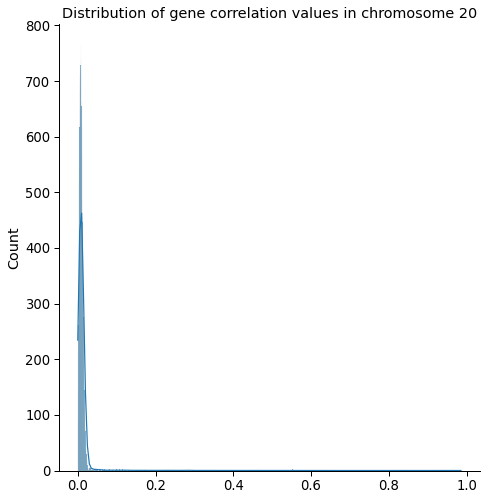

In [43]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(gene_corrs, kde=True, height=7)
    g.ax.set_title(
        f"Distribution of gene correlation values in chromosome {chromosome}"
    )

## Plot: heatmap

In [44]:
vmin_val = min(-0.05, gene_corrs_quantiles[0.10])
vmax_val = max(0.05, gene_corrs_quantiles[0.90])
display(f"{vmin_val} / {vmax_val}")

'-0.05 / 0.05'

Text(0.5, 1.0, 'Gene correlations in chromosome 20')

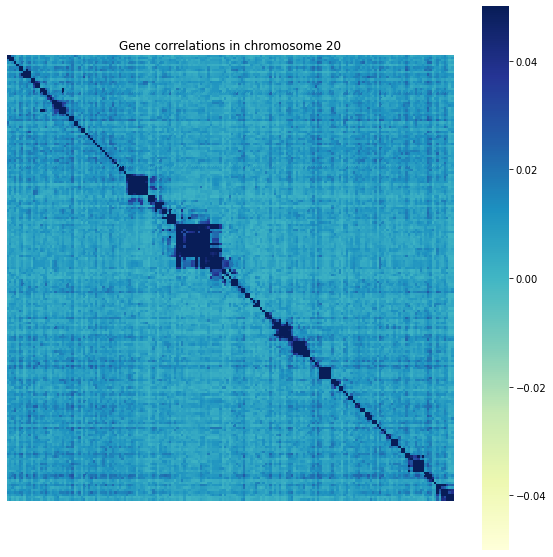

In [45]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    gene_corrs_df,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="YlGnBu",
    ax=ax,
)
ax.set_title(f"Gene correlations in chromosome {chromosome}")